In [2]:

import torch
from time import time
from DocBuilder.utils import split_list_to_batch, restore_batched_list, unbind_sparse, top_k_sparse, tensor_retuen_type
from DocBuilder.Retriever_k_means import cluster_builder
import matplotlib.pyplot as plt
import numpy as np

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


168


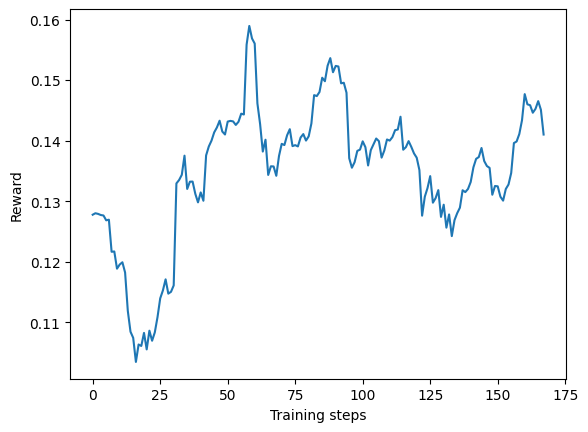

In [19]:

with open("reward_number_0.log", "r") as f:
    r = f.readlines()
r = [float(i) for i in r][25800:]
print(len(r))
moving_avg = []
ma = np.mean(r[:150])
ratio=1-10/len(r)
for x in r:
    ma = ratio * ma + (1-ratio) * x
    moving_avg.append(ma)

plt.ylabel("Reward")
plt.xlabel("Training steps")
plt.plot(moving_avg)
plt.show()

tensor(0.0016)


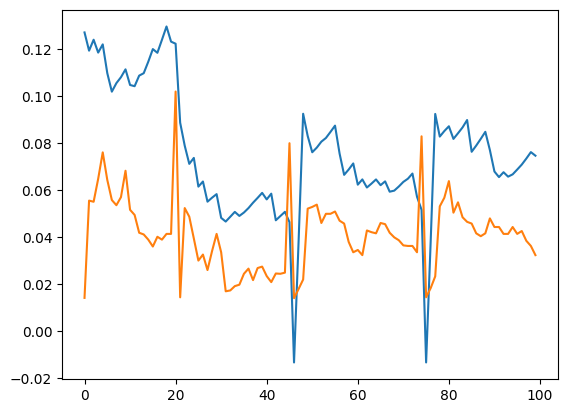

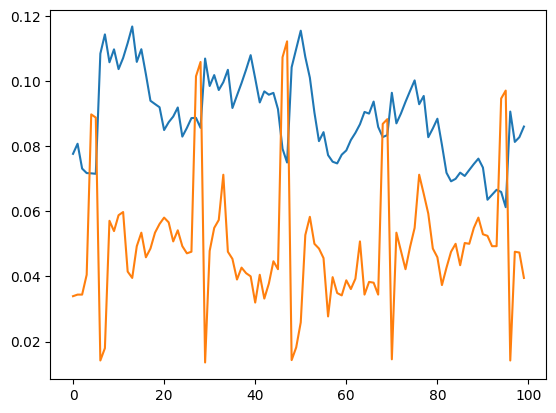

In [15]:
returns = torch.load("save/return.pt")
value = torch.load("save/value.pt")
print((returns - value).square().mean())
plt.plot(returns[:100])
plt.plot(value[:100])
plt.show()
plt.plot(returns[100:200])
plt.plot(value[100:200])
plt.show()

In [1]:
from RL.utils import BertAgentCritic
from config import agent_size_config
import torch
a=BertAgentCritic(agent_size_config,3).to(torch.bfloat16)
ac,va=a("hello "*1000)

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 32])
torch.Size([1, 32])
torch.Size([1, 32, 768])


In [31]:
class env:
    def __init__(self) -> None:
        pass
    def step(self, action):
        if action==0:
            reward = 0.5
        elif action==1:
            reward= 1
        elif action==2:
            reward = 0.01
        
        return reward
import torch
e = env()

value = torch.zeros([11])
smoothing = 0.1
for epoch in range(1000):
    rewards = []
    for i in range(10):
        a = torch.randint(3, size = [1])[0]
        r = e.step(a)
        rewards.append(r)
    rewards = torch.tensor(rewards)
    print("reward:",rewards)
    returns = value[1:]*0.99 + rewards
    print("returns:",returns)
    value[:10] = value[:10]*(1-smoothing) + returns*smoothing
    print("value:",value[:10])

plt.plot(returns)
plt.plot(value)
plt.show()

reward: tensor([0.0100, 1.0000, 1.0000, 0.0100, 1.0000, 0.0100, 0.0100, 0.5000, 1.0000,
        0.5000])
returns: tensor([0.0100, 1.0000, 1.0000, 0.0100, 1.0000, 0.0100, 0.0100, 0.5000, 1.0000,
        0.5000])
value: tensor([0.0010, 0.1000, 0.1000, 0.0010, 0.1000, 0.0010, 0.0010, 0.0500, 0.1000,
        0.0500])
reward: tensor([0.5000, 0.0100, 0.0100, 0.0100, 1.0000, 1.0000, 1.0000, 0.0100, 0.5000,
        0.0100])
returns: tensor([0.5990, 0.1090, 0.0110, 0.1090, 1.0010, 1.0010, 1.0495, 0.1090, 0.5495,
        0.0100])
value: tensor([0.0608, 0.1009, 0.0911, 0.0118, 0.1901, 0.1010, 0.1059, 0.0559, 0.1450,
        0.0460])
reward: tensor([0.0100, 1.0000, 0.0100, 0.5000, 0.0100, 0.5000, 1.0000, 1.0000, 0.5000,
        1.0000])
returns: tensor([0.1099, 1.0902, 0.0217, 0.6882, 0.1100, 0.6048, 1.0553, 1.1435, 0.5455,
        1.0000])
value: tensor([0.0657, 0.1998, 0.0842, 0.0794, 0.1821, 0.1514, 0.2008, 0.1647, 0.1850,
        0.1414])
reward: tensor([0.5000, 0.0100, 1.0000, 0.0100, 1.0000,